# Coursera Capstone Project: The Battle of Neighborhoods Week 2

## Project Title: Deciding on a New Restaurant in Johnson City, Tennessee

## Student: Jonathan Burritt
## Submitted: 8-5-20

This notebook provides the data analysis for the report:

* "Deciding on a New Restaurant in Johnson City, Tennessee"

Please see the full report for more details.

## Libraries

In [1]:
# Standard libaries

# For data structures

import pandas as pd

# For basic plottting

from matplotlib import pyplot as plt
%matplotlib inline

# For advanced plotting

import seaborn as sns

# For scientific computing

import numpy as np

# For python system functions


import sys

# For clustering

import random
from sklearn.cluster import KMeans 
from sklearn.datasets.samples_generator import make_blobs

# For normalizing data

from sklearn.preprocessing import StandardScaler

# For plotting in 3D

from mpl_toolkits.mplot3d import Axes3D

# For capstone project

import folium
from bs4 import BeautifulSoup
import requests
import lxml
import html5lib
from pandas.io.html import read_html

import random
from geopy.geocoders import Nominatim
from IPython.display import Image 
from IPython.core.display import HTML
from pandas.io.json import json_normalize


c:\users\wayne\appdata\local\programs\python\python38\lib\site-packages\sklearn\utils\deprecation.py:143: FutureWarning: The sklearn.datasets.samples_generator module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.datasets. Anything that cannot be imported from sklearn.datasets is now part of the private API.
  warnings.warn(message, FutureWarning)


## Display options

In [2]:
# Config option for displaying output
# Default is 'last_expr'

#from IPython.core.interactiveshell import InteractiveShell
#InteractiveShell.ast_node_interactivity = "all"

# Set display options to all columns and rows

pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows', None)


## Data wrangling of all venues from Foursquare

In [3]:
# Load credentials from foursquare

client_id = '******'
client_secret = '******'
version = '20200701'
print('Your credentials:')
print('client_id: ' + client_id)
print('client_secret:' + client_secret)

# Find location of Johnson City

address = '300 E Main St, Johnson City, TN'
geolocator = Nominatim(user_agent="foursquare_agent")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print(latitude, longitude)

# Create paramters for search

radius = 1000
limit = 500

url = ('https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&v={}&radius={}&limit={}'.
      format(client_id, client_secret, latitude, longitude, version, radius, limit))
            
url


Your credentials:
client_id: MLUDW4VQQPA4IMG3BRBHP5EDPZVBUYKDP5F4MQEZH4YSXLKH
client_secret:G4SOQGWSBV5QZM4UBSUIGTEURU3RZDY1FDAY5Y52L0PUMTTK
36.3172576 -82.3507846


'https://api.foursquare.com/v2/venues/search?client_id=MLUDW4VQQPA4IMG3BRBHP5EDPZVBUYKDP5F4MQEZH4YSXLKH&client_secret=G4SOQGWSBV5QZM4UBSUIGTEURU3RZDY1FDAY5Y52L0PUMTTK&ll=36.3172576,-82.3507846&v=20200701&radius=1000&limit=500'

## Dataframe of all venues

In [4]:
# Extract relevant part of JSON

results = requests.get(url).json()
venues = results['response']['venues']
df_venues = json_normalize(venues)

# Export to csv for safekeeping

df_venues.to_csv('venues.csv')

# Keep columns that include venue name and anything associated with location

filtered_columns = ['name', 'categories'] + [col for col in df_venues.columns if col.startswith('location.')] + ['id']
df_venues_filtered = df_venues.loc[:, filtered_columns]

# Run function that extracts the category of the venue

def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']


df_venues_filtered['categories'] = df_venues_filtered.apply(get_category_type, axis=1)
df_venues_filtered.columns = [column.split('.')[-1] for column in df_venues_filtered.columns]
df_venues_filtered.sort_values(['name'], inplace=True)


<ipython-input-4-fbe9ee4f49fb>:5: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  df_venues = json_normalize(venues)


## Dataframe of all venues

In [5]:
# Explore dataframe

df_venues_filtered.head()


,name,categories,address,crossStreet,lat,lng,labeledLatLngs,distance,postalCode,cc,city,state,country,formattedAddress,id
102,#occupyjohnsoncity,Field,NaN,NaN,36.315938,-82.349875,"[{'label': 'display', 'lat': 36.31593814887468, 'lng': -82.34987511371533}]",168,NaN,US,NaN,Tennessee,United States,"[Tennessee, United States]",4e999b105c5caa2f4519c541
73,112,None,NaN,NaN,36.316909,-82.351496,"[{'label': 'display', 'lat': 36.31690884694869, 'lng': -82.35149623132787}]",74,37601,US,Johnson City,TN,United States,"[Johnson City, TN 37601, United States]",4d732a68d145a1cd90e6bff3
91,2 Dye 4,Boutique,NaN,NaN,36.316238,-82.351931,"[{'label': 'display', 'lat': 36.316237901728584, 'lng': -82.35193064207675}]",153,37604,US,Johnson City,TN,United States,"[Johnson City, TN 37604, United States]",4f0732bae4b09a8a3da63599
115,4tress Studios,Rock Club,85 Buffalo St,NaN,36.316582,-82.352639,"[{'label': 'display', 'lat': 36.316582, 'lng': -82.352639}, {'label': 'entrance', 'lat': 36.316475, 'lng': -82.352661}]",182,37604,US,Johnson City,TN,United States,"[85 Buffalo St, Johnson City, TN 37604, United States]",4d7c0aa4136bf04dbd00588d
92,AVI,Building,207 E Main St,Buffalo,36.316920,-82.352032,"[{'label': 'display', 'lat': 36.31692, 'lng': -82.352032}]",118,37604,US,Johnson City,TN,United States,"[207 E Main St (Buffalo), Johnson City, TN 37604, United States]",4d839f09f1e56ea8c06b648a


In [6]:
# Explore dataframe

df_venues_filtered.shape


(123, 15)

## Folium map of all venues

In [7]:
# Plot all restaurants with an optimal zoom

venues_map = folium.Map(location=[latitude, longitude], zoom_start=20)

# Add red circle marker for the center of Downtown

folium.CircleMarker(
    [latitude, longitude],
    radius=10,
    color='red',
    popup='Center of Downtown',
    fill = True,
    fill_color = 'red',
    fill_opacity = 0.6
).add_to(venues_map)

# Add all venues near the center of Downtown

for lat, lng, label in zip(df_venues_filtered.lat, df_venues_filtered.lng, df_venues_filtered.categories):
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        color='blue',
        popup=label,
        fill = True,
        fill_color='blue',
        fill_opacity=0.6
    ).add_to(venues_map)
    
# Display map

venues_map

## Bar plot of all venues by category

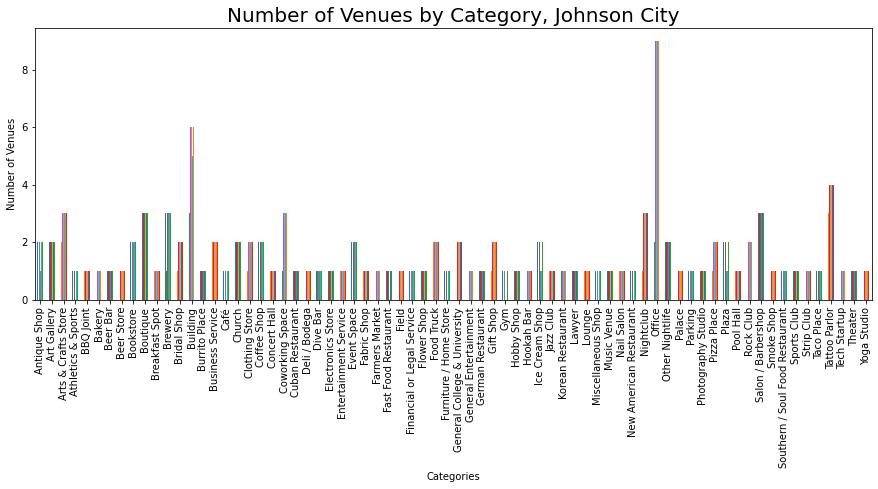

In [8]:
# Data wrangling

df_venues_bar = df_venues_filtered.groupby('categories').count()

# Plot the data

df_venues_bar.plot(kind='bar', figsize=(15,5), legend=False)

# Customize labels

plt.xlabel('Categories')
plt.ylabel('Number of Venues')
plt.title('Number of Venues by Category, Johnson City', fontsize=20)

# Show plot

plt.show()


## Data wrangling of all restaurants from Foursquare

In [9]:
# Create dataframe of just restaurants

df_rest = df_venues_filtered[df_venues_filtered['categories'].str.contains('Restaurant', na = False)]
df_rest.sort_values(['name'], inplace=True)


<ipython-input-9-157c3ecccf6f>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_rest.sort_values(['name'], inplace=True)


## Dataframe of all restaurants

In [10]:
# Explore dataframe

df_rest


,name,categories,address,crossStreet,lat,lng,labeledLatLngs,distance,postalCode,cc,city,state,country,formattedAddress,id
5,Freiberg's,German Restaurant,203 E Main St,at Spring St,36.316382,-82.352567,"[{'label': 'display', 'lat': 36.316382369881445, 'lng': -82.35256692569367}]",187,37604,US,Johnson City,TN,United States,"[203 E Main St (at Spring St), Johnson City, TN 37604, United States]",4b4771a5f964a5204a3226e3
18,Korean Taco House,Korean Restaurant,101 Buffalo St,Main Street,36.316096,-82.352646,"[{'label': 'display', 'lat': 36.316096, 'lng': -82.352646}]",211,37604,US,Johnson City,TN,United States,"[101 Buffalo St (Main Street), Johnson City, TN 37604, United States]",52420b9811d247e40c81f2f8
11,McDonald's,Fast Food Restaurant,NaN,NaN,36.318582,-82.350453,"[{'label': 'display', 'lat': 36.318581819104104, 'lng': -82.35045257495463}]",150,NaN,US,Johnson City,TN,United States,"[Johnson City, TN, United States]",5165bd33e4b04adace3cbce2
15,Saborés,Cuban Restaurant,202 E Main St,NaN,36.316316,-82.352130,"[{'label': 'display', 'lat': 36.316316, 'lng': -82.35213}, {'label': 'entrance', 'lat': 36.316439, 'lng': -82.352168}]",159,37604,US,Johnson City,TN,United States,"[202 E Main St, Johnson City, TN 37604, United States]",59952b73603d2a64d3373e68
87,Taste Budz,Southern / Soul Food Restaurant,300 S Roan St,NaN,36.317323,-82.351083,"[{'label': 'display', 'lat': 36.317322999999995, 'lng': -82.351083}, {'label': 'entrance', 'lat': 36.317543, 'lng': -82.351061}]",27,37601,US,Johnson City,TN,United States,"[300 S Roan St, Johnson City, TN 37601, United States]",4f3290eb19836c91c7e448c0
100,bacon fest,New American Restaurant,NaN,NaN,36.317093,-82.350525,"[{'label': 'display', 'lat': 36.31709289550781, 'lng': -82.35052490234375}]",29,NaN,US,Johnson City,TN,United States,"[Johnson City, TN, United States]",522b72c511d20dc0b91abb44


In [11]:
# Explore dataframe

df_rest.shape


(6, 15)

## Folium map of all restaurants in Johnson City

In [12]:
# Plot all restaurants with an optimal zoom

rest_map = folium.Map(location=[latitude, longitude], zoom_start=20)

# Add red circle marker for the center of Downtown

folium.CircleMarker(
    [latitude, longitude],
    radius=10,
    color='red',
    popup='Center of Downtown',
    fill = True,
    fill_color = 'red',
    fill_opacity = 0.6
).add_to(rest_map)

# Add all restaurants near the center of Downtown

for lat, lng, label in zip(df_rest.lat, df_rest.lng, df_rest.name):
    folium.CircleMarker(
        [lat, lng],
        radius=15,
        color='pink',
        popup=label,
        fill = True,
        fill_color='green',
        fill_opacity=0.6
    ).add_to(rest_map)
    
# Display map

rest_map


## Export restaurant dataframe to excel

In [13]:
# Drop unwanted columns for excel export

df_rest_excel = df_rest[['name', 'categories', 'address', 'city']]

# Reset index to restaurant name

df_rest_excel.set_index('name', inplace=True)

# Export excel file of downtown restaurants

df_rest_excel.to_excel('johnson_city_restaurants.xlsx')


## Data wrangling of key economic data from U.S. Census Bureau

In [14]:
# Data wrangling of key economic data

# Load data

df_econ = pd.read_csv('johnson_city_econ.csv')

# Rename key columns

df_econ.rename({'Fact':'data_name', 'Johnson City city, Tennessee':'johnson_city', 'Tennessee': 'tn'}, axis=1, inplace=True)

# Retain only key columns

df_econ = df_econ[['data_name', 'johnson_city', 'tn']]

# Drop rows with null values

df_econ.dropna(subset = ['johnson_city', 'tn'], inplace=True)

# Drop rows with unusable values 

drop_rows = df_econ[df_econ['johnson_city']=='X'].index
df_econ.drop(drop_rows, inplace=True)

# Replace strings of various characters with no characters and change data type

df_econ['johnson_city'] = df_econ['johnson_city'].str.replace(',', '')
df_econ['johnson_city'] = df_econ['johnson_city'].str.replace('$', '')
df_econ['johnson_city'] = df_econ['johnson_city'].str.replace('%', '')
df_econ['johnson_city'] = df_econ['johnson_city'].str.replace('"', '')
df_econ['johnson_city'] = df_econ['johnson_city'].astype(float)

df_econ['tn'] = df_econ['tn'].str.replace(',', '')
df_econ['tn'] = df_econ['tn'].str.replace('$', '')
df_econ['tn'] = df_econ['tn'].str.replace('%', '')
df_econ['tn'] = df_econ['tn'].str.replace('"', '')
df_econ['tn'] = df_econ['tn'].astype(float)

# Reset index and drop original index lables

df_econ.reset_index(drop=True, inplace=True)

# Reset index and rename key rows

df_econ.set_index('data_name', inplace=True)
df_econ.rename(index={'Per capita income in past 12 months (in 2018 dollars), 2014-2018':'income_per_cap', 'Total retail sales per capita, 2012':'retail_per_cap', 'Median value of owner-occupied housing units, 2014-2018':'avg_house_val'}, inplace=True)
df_econ.reset_index(inplace=True)

# Create new dataframe of key columns and rows

df_econ_filtered = df_econ[(df_econ['data_name']=='income_per_cap') | (df_econ['data_name'] == 'retail_per_cap') | (df_econ['data_name'] == 'avg_house_val')]
df_econ_filtered.sort_index(ascending=False, inplace=True)


<ipython-input-14-0a8a42ecabca>:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_econ_filtered.sort_index(ascending=False, inplace=True)


## Dataframe of key economic data

In [15]:
# Explore dataframe

df_econ_filtered.sort_values(['data_name'], inplace=True)
df_econ_filtered


<ipython-input-15-46df1b72969c>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_econ_filtered.sort_values(['data_name'], inplace=True)


,data_name,johnson_city,tn
19,avg_house_val,165900.0,158600.0
43,income_per_cap,29707.0,28511.0
40,retail_per_cap,27593.0,14194.0


In [16]:
# Explore dataframe

df_econ_filtered.shape


(3, 3)

## Bar plot of key economic data

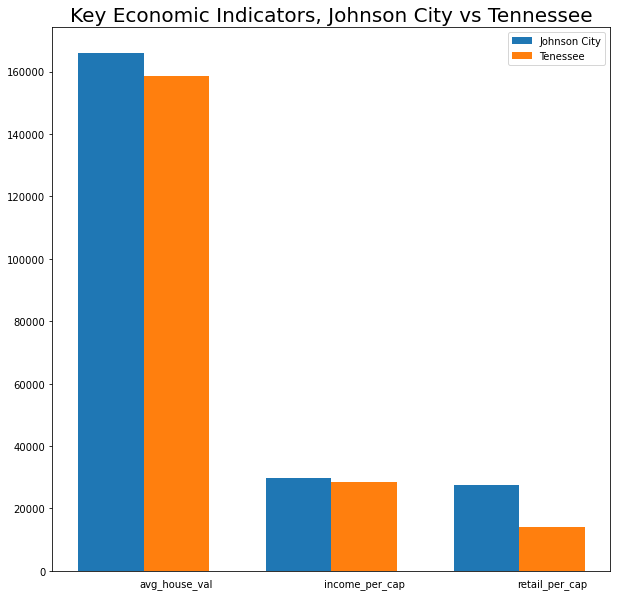

In [17]:
# Set size of plot

plt.figure(figsize=(10, 10))

# Set width of bars

barWidth = 0.35
 
# Set height of bars

bars_jc = df_econ_filtered['johnson_city']
bars_tn = df_econ_filtered['tn']
 
# Set x axis bar position

r1 = np.arange(len(bars_jc))
r2 = [x + barWidth for x in r1]

# Plot the data

plt.bar(r1, bars_jc, width=barWidth, label='Johnson City')
plt.bar(r2, bars_tn, width=barWidth, label='Tenessee')
 
# Customize tick marks and labels

#plt.xticks([r + barWidth for r in range(len(bars_jc))], ['Income per Capita', 'Retail Sales per Capita', 'Median House Value'])
plt.xticks([r + barWidth for r in range(len(bars_jc))], df_econ_filtered['data_name'])
plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=True)
plt.title('Key Economic Indicators, Johnson City vs Tennessee', fontsize=20)

# Show plot

plt.legend()
plt.show()
